# SCS 3546 Deep Learning 

# Module 05: Recurrent Neural Networks
***

## Module Outline


- Recurrent Neurons 
- Basic RNNs in TensorFlow 
- Training RNNs 
- Deep RNNs 
- LSTM Cell 
- GRU Cell 

    
## Learning Outcomes

By the end of this module, you will:

- Understand the fundamental concepts underlying RNNs. 
- Be able to implement RNNs using TensorFlow and Keras. 
- Gain familiarity with different types of recurrent cells: LSTMs and GRUs. 
- Have exposure to different sequence modelling tasks that RNNs are well-suited for. 




## Introduction

Recurrent Neural Networks (RNNs) specialize in sequence-prediction tasks. Unlike fully-connected networks, RNNs can ingest sequences of arbitrary lengths. These can be sentences, documents, audio samples, and so forth, making them extremely versatile. Some examples of their applications include:

- predicting future events from time-series data, such as stock prices
- anticipating car trajectories in autonomous driving systems
- analyzing a sequence of words to generate a sentiment 
- translating sentences from one language to another
- generating of image captions
- composing a melody that continues a sequence of input notes in the same musical style



Let's start simple and examine the fundamental concepts underlying RNNs and how to train them. 

## Setup

First, let's make sure this notebook has all the required libraries, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [ ]:
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
from IPython.display import Image
import tensorflow as tf
import tensorflow.keras as keras

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

%matplotlib inline


# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"

# helper functions
def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)
    
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image.astype(np.uint8),interpolation="nearest")
    plt.axis("off")



# Recurrent Neurons

To process a sequence $[x_{(0)}, x_{(1)}, x_{(2)}, ...]$ with an RNN, you feed each element of the sequence into the RNN, one at a time. We call each of these 'steps' a timestep $t$. So the RNN would see the input vector $x_{(0)}$ during timestep $t_0$, the vector $x_{(1)}$ at timestep $t_1$, and so forth. Note that generally, $x_{(0)}$ could represent a single value at time $t$, such as a stock price, or a vector of values, such as the pixels of a video frame. 

How can we ensure that a neuron's prediction at a given timestep $t$ takes into account the inputs it saw at previous timesteps? One simple approach would be to feed the neuron's output back into itself, hence the idea of recursion. 

Let’s look at the simplest possible RNN: one cell with feedback.
- At each time step t, this recurrent neuron receives the inputs $x(t)$ as well as its own output from the previous time step, $y(t–1)$. 
- We can represent this tiny network against the time axis. This is called unrolling the network through time (see image below).


<center><img src="https://drive.google.com/uc?id=1APTz3hmUynG8GJspgaKnjh_4tZfaUzsd" ></center>



Now, to create a layer of these recursive neurons:
- Every neuron receives both the input vector $x(t)$ and the output vector from the previous time step $y(t–1)$. 
- Note that both the inputs and outputs are vectors now 

<center><img src="https://drive.google.com/uc?id=1IAWzmhjpz8IM9xKmKmbdMmtGFCALOGxL" ></center>

Each recurrent neuron has two sets of weights: 
- for the inputs $x(t)$: $W_x$
- for the outputs of the previous time step, $y(t–1)$: $W_y$
- We can place all the weight vectors for all neurons in two weight matrices, $W_x$ and $W_y$. 
- The output vector of the whole recurrent layer can then be computed as:  


$$
\mathbf{y}_{(t)}=\phi\left(\mathbf{W}_{x}{ }^{T} \mathbf{x}_{(t)}+\mathbf{W}_{y}{ }^{T} \mathbf{y}_{(t-1)}+\mathbf{b}\right)
$$

Where $b$ is the bias vector and $\phi(.)$ is the nonlinear activation function.


We can compute a recurrent layer’s output in one shot for a whole mini-batch :


$$
\begin{aligned} \mathbf{Y}_{(t)} &=\phi\left(\mathbf{X}_{(t)} \mathbf{W}_{x}+\mathbf{Y}_{(t-1)} \mathbf{W}_{y}+\mathbf{b}\right) \\ &=\phi\left(\left[\begin{array}{ll}\mathbf{X}_{(t)} & \mathbf{Y}_{(t-1)}\end{array}\right] \mathbf{W}+\mathbf{b}\right) \text { with } \mathbf{W}=\left[\begin{array}{l}\mathbf{W}_{x} \\ \mathbf{W}_{y}\end{array}\right] \end{aligned}
$$

- $Y(t)$ is an $m \times n_{neurons}$ matrix containing the layer’s outputs at time step $t$ for each instance in the mini-batch (m is the number of instances in the mini-batch).

- $X(t)$ is an $m \times n_{inputs}$ matrix containing the inputs for all instances 

- $W_x$ is an $n_{inputs} \times n_{neurons}$ matrix containing the connection weights of the current step.

- $W_y$ is an $n_{neurons} × n_{neurons}$ matrix containing the connection weights for the outputs of the previous time step.

- $b$ is a vector of size $n_{neurons}$ containing each neuron’s bias term.

The weight matrices $W_x$ and $W_y$ are often concatenated vertically into a single weight matrix $W$

The notation $[X(t) Y(t–1)]$ represents the horizontal concatenation of the matrices $X(t)$ and $Y(t–1)$.

Notice that Y(t) is a function of X(t) and Y(t–1), which is a function of X(t–1) and Y(t–2), which is a function of X(t–2) and Y(t–3), and so on. 



# Memory Cells

Here's another way of looking at the above. What makes Recurrent Neural Networks different from what we've seen before, is that they maintain a hidden internal state $h_{(t)}$ that serves as a form of memory. This internal state $h_{(t)}$ depends both on the input $x_{(t)}$ at time step $t$, as well as the internal state in the previous timestep, $h_{(t-1)}$. 


- The output of a recurrent neuron at time $t$ is a function of all the inputs from previous times

- In general, a cell’s state $h_{(t)}$ is a function of some inputs $x_{(t)}$ and its state at the previous time step: $h_{(t)} = f(h_{(t–1)}, x_{(t)})$
    
- The network's output $y_{(t)}$, is also a function of the previous $y_{(t-1)}$ and $x_{(t)}$. 

Another way of expressing feed-forward through a RNN, which might make the logic somewhat clearer, is:


$$
h_{(t)} = \phi\left(W^{T}_{hh}h_{(t-1)} + W^{T}_{xh}x_{(t)}\right)
$$

$$
y_{(t)}= \phi\left(W^{T}_{hy}h_{(t)} \right)
$$

Where $W_{xh}$ is a weights matrix that connects the input to the hidden cell state; $W_{hh}$ is a weights matrix that connects the hidden cell state to itself in the previous timestep; $W_{hy}$ is a weights matrix connecting the hidden state to the predicted output, and $\phi(.)$ represents a nonlinear activation function, as before. In the above, we have implicitly incorporated the bias term into the weight matrices. 

<center><img src="https://drive.google.com/uc?id=1p1KtbVG3rxs1jL15ZJIkHlX8mkdPLzRM" ></center>


# Input and Output Sequences

There are multiple ways we can ingest an input and generate our output. 


- **Many-to-many sequence prediction:** An RNN can simultaneously take a sequence of inputs and produce a sequence of outputs, e.g. predicting a time series. (Top-left image)


- **Many-to-one prediction:** RNNs can also take a sequence of inputs, and ignore all outputs except for the last one, e.g. feed the network a sequence of words corresponding to a movie review, and the network would output a sentiment score (e.g., from –1 [hate] to +1 [love]). (Top-right image)
    

- **One-to-many prediction:** in this case the RNN takes a single input at the first time step and zeros for all others; e.g. a network that ingests an image on the first timestep, and exports a text description of that image across multiple subsequent time steps. (Bottom-left image)

- **Encoder-Decoder**: We can also chain a many-to-one network (e.g. encoder) with a one-to-many network (e.g. decoder). This 'Encoder-Decoder' two-step model is often used for sentence translation; since the last words of a sentence might impact the first words of the translation, it's useful to ensure the entire input sequence has been ingested first, before proceeding with generating the translation. (Bottom right image)



<center><img src="https://drive.google.com/uc?id=1ut-l3DRwhvds8WtqcNQw2DcnBtcX6wFx" ></center>



When training an RNN, we need to compute a loss at each timestep. This is shown in the diagram below. We then typically sum the losses across all timesteps to get the total loss. 

Note that, in the literature, you're going to see quite a few different forms of notation. The diagram below denotes the recurrent layer output prior to the final activation function as $O$, and represents the weight matrices as $W = W_{hh}$, $V = W_{hy}$, and $U = W_{xh}$.

<center><img src="https://drive.google.com/uc?id=1cwiS24E1J6HKVh7rTU7IX7KB0RaXhoNN" ></center>

$$
\begin{array}{l}{\boldsymbol{a}^{(t)}=\boldsymbol{b}+\boldsymbol{W} \boldsymbol{h}^{(t-1)}+\boldsymbol{U} \boldsymbol{x}^{(t)}} \\ {\boldsymbol{h}^{(t)}=\tanh \left(\boldsymbol{a}^{(t)}\right)} \\ {\boldsymbol{o}^{(t)}=\boldsymbol{c}+\boldsymbol{V} \boldsymbol{h}^{(t)}} \\ {\hat{\boldsymbol{y}}^{(t)}=\operatorname{softmax}\left(\boldsymbol{o}^{(t)}\right)}\end{array}
$$

# RNN Variants

There are a few other ways of implementing an RNN. For example, in the RNN depicted below, the only recurrence is the feedback connection from the output to the hidden layer, instead of the hidden cell state to itself.

<center><img src="https://drive.google.com/uc?id=1fA8SalfBnRwPmEz7tI6DfXIwvGrCxqC2" ></center>

**Bidirectional RNNs** are a fairly important variant. They consist of two RNNs training the network in opposite directions. One RNN starts from the beginning of the sequence and works its way to the end. The other RNN starts at the end and works its way to the beginning. This helps the network take the entire context of the input sequence into account, instead of only being limited by what it has seen in the 'past' and 'present' and it steps through the sequence. The two RNNs are represented by the $g$ and $h$ hidden cell states below.



<center><img src="https://drive.google.com/uc?id=1aMhWHHOlYP74vcejp5RGC-aqSY5lcWLl" ></center>

$$
\begin{array}{l}{\bar{h}_{t}^{(f)}=\tanh \left(W_{x h}^{(f)} \bar{x}_{t}+W_{h h}^{(f)} \bar{h}_{t-1}^{(f)}\right)} \\ {\bar{g}_{t}^{(b)}=\tanh \left(W_{x g}^{(b)} \bar{x}_{t}+W_{g g}^{(b)} \bar{g}_{t+1}^{(b)}\right)} \\ {\bar{o}_{t}=W_{h y}^{(f)} \bar{h}_{t}^{(f)}+W_{g y}^{(b)} \bar{g}_{t}^{(b)}}\end{array}
$$

Teacher forcing and networks with output recurrence
<center><img src="https://drive.google.com/uc?id=11RVNyTbbIsX7WIg_Xt_ZXijBPJdWQPIV" ></center>

Here are a few others you might see, although we won't go into details here:

Modeling sequences conditioned on context: an RNN that maps a ﬁxed-length vector $x$ into a distribution over sequences $Y$. 

<center><img src="https://drive.google.com/uc?id=1n6Rikao4cgIgh6ogFMtRN_CfvE_5b95X" ></center>


A conditional recurrent neural network mapping a variable-length sequence of $x$ values into a distribution over sequences of $y$ values of the same length.

<center><img src="https://drive.google.com/uc?id=1_YZwZyca0B6negcRT7glwi6UbLINSwS-" ></center>

Encoder-decoder sequence-to-sequence architecture:

<center><img src="https://drive.google.com/uc?id=1k87zptKYoNpDoNmWzb5Q3enUEMeV75D6" ></center>

# Training RNNs

RNNs use a modified version of backpropagation, called "Back Propagation Through Time" (BPTT). Gradients flow not only via the output of each cell, but also through each time step via the hidden cell state. The approach is to unroll the RNN through time and then use regular backpropagation.




<center><img src="https://drive.google.com/uc?id=1ixYssb7qufxQ_0Tw95haM-wVEbs645rh" ></center>

- There is a first forward pass through the unrolled network ; 
- then the output sequence is evaluated using a cost function 
- and the gradients of that cost function are propagated backward through the unrolled network 
- finally the model parameters are updated using the gradients computed during BPTT. 

Note that the gradients flow backward through all the outputs used by the cost function, not just through the final output. 

Since the same parameters W and b are used at each time step, backpropagation will do the right thing and sum over all time steps.

For large sequences, we end up with many chained matrix multiplications of $W$ with itself. If the values of W are large, this could lead to exploding gradients (covered in Module 2). One way to mitigate that is through gradient clipping. On the other hand, if $W$ is too small, we might get vanishing gradients. We already know how to mitigate this from Module 2. This can be countered by non-saturating activation functions and proper weight initialization strategies. A third technique to mitigate vanishing or exploding gradients is the concept of gated units, which we'll discuss later in this module. 



# Forecasting a Time Series

Let's see an RNN in action! For this demo, we'll generate some time-series data and ask our network to make some forecasts to predict the next value in the sequence (many-to-one prediction).

## Generate the Dataset

In [ ]:
# here we define our time series as a superposition of two
# random-frequency sine waves with a random offset
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [ ]:
# let's generate a dataset of 10000 sample sequences, each having 50 timesteps
n_steps = 50
series = generate_time_series(10000, n_steps + 1) # we'll actually request 51 steps

# the first 50 steps will be our training data, the final (51st) step is what we are trying to predict;
# therefore this is a many-to-one type prediction problem
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [ ]:
# the training data has 7000 samples, each being a 50-element sequence of scalars
print(f"X_train shape: {X_train.shape}")

# the target is just a single scalar value, for each sample sequence
print(f"Y_train shape: {y_train.shape}")


X_train shape: (7000, 50, 1)
Y_train shape: (7000, 1)


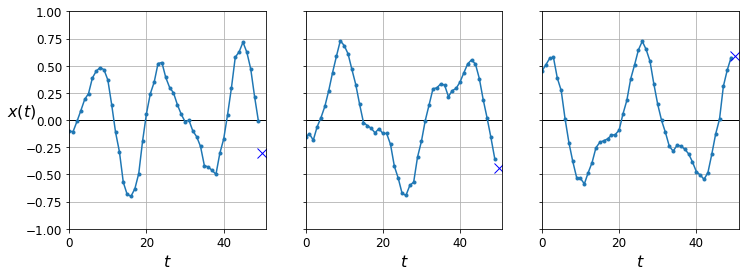

In [ ]:
# let's now view some examples of what these time series
# sequences look like

def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
plt.show()

In [ ]:
# let's start with a simple heuristic model as a benchmark;
# what if we simply guess that the 51st element was equal to the 50th?
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.021133143

Let's build a simple RNN model. 

Note that the default activation for an RNN is `tanh()`, and we'll keep this as-is. Why? Recurrent networks are one of the few scenarios where `ReLU` could actually do more harm than good. Since `ReLU` is non-saturating, a small gradient increase might be continuously amplified across time steps during backpropagation-through-time, leading to exploding gradients. In this case the 'regularization' effect of `tanh`, which always caps values between -1 and 1, helps with stabilization. Hence why you'll see `tanh` frequently used in RNNs instead of `ReLU`. 

In [ ]:
# we'll build a super-simple RNN that has only one layer and one recursive unit;
# this is the simplest it gets
model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1]),
])

optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(
    X_train,
    y_train, 
    epochs=5,
    validation_data=(X_valid, y_valid)
)

Epoch 1/5
219/219 [==============================] - 10s 41ms/step - loss: 0.1148 - val_loss: 0.0364
Epoch 2/5
219/219 [==============================] - 14s 65ms/step - loss: 0.0303 - val_loss: 0.0256
Epoch 3/5
219/219 [==============================] - 8s 38ms/step - loss: 0.0225 - val_loss: 0.0199
Epoch 4/5
219/219 [==============================] - 7s 33ms/step - loss: 0.0181 - val_loss: 0.0166
Epoch 5/5
219/219 [==============================] - 7s 31ms/step - loss: 0.0155 - val_loss: 0.0146


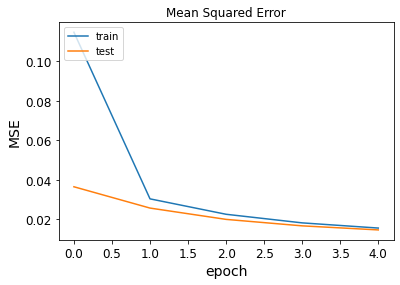

In [ ]:
# let's examine the learning curves
def plot_learning_curves(history):

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Mean Squared Error')
  plt.ylabel('MSE')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

plot_learning_curves(history)

In [ ]:
# we're approaching our heuristic model's performance, but we can 
# probably do much better; after all, we only have 3 trainable parameters here
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 1)                 3         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


### Adding more parameters 

In [ ]:
# this time we'll use 10 recursive units in our layer, and
# add a dense layer of 1 unit
model = keras.models.Sequential([
    keras.layers.SimpleRNN(10, input_shape=[None, 1], activation='tanh'),
    keras.layers.Dense(1, activation=None)
])

optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
219/219 [==============================] - 8s 32ms/step - loss: 0.0113 - val_loss: 0.0051
Epoch 2/10
219/219 [==============================] - 7s 32ms/step - loss: 0.0052 - val_loss: 0.0049
Epoch 3/10
219/219 [==============================] - 7s 33ms/step - loss: 0.0050 - val_loss: 0.0049
Epoch 4/10
219/219 [==============================] - 7s 31ms/step - loss: 0.0049 - val_loss: 0.0048
Epoch 5/10
219/219 [==============================] - 7s 31ms/step - loss: 0.0048 - val_loss: 0.0046
Epoch 6/10
219/219 [==============================] - 8s 35ms/step - loss: 0.0048 - val_loss: 0.0046
Epoch 7/10
219/219 [==============================] - 8s 35ms/step - loss: 0.0046 - val_loss: 0.0047
Epoch 8/10
219/219 [==============================] - 7s 31ms/step - loss: 0.0047 - val_loss: 0.0050
Epoch 9/10
219/219 [==============================] - 7s 33ms/step - loss: 0.0047 - val_loss: 0.0046
Epoch 10/10
219/219 [==============================] - 7s 31ms/step - loss: 0.0047 - val_lo

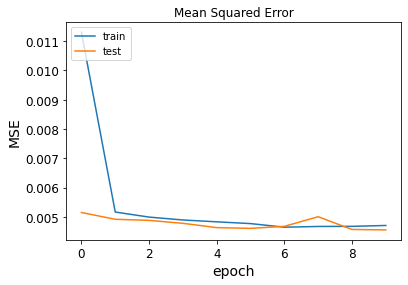

In [ ]:
# even with this relatively simple model, we are quickly outperforming our 
# heuristic (which had MSE of 0.020)
plot_learning_curves(history)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 10)                120       
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


## Deep RNNs

What about adding additional layers of recursive units? It is actually quite straightforward to stack multiple layers of recursive units on top of each other. 

<center><img src="https://drive.google.com/uc?id=17Jyn1BBQ9zxCi1BBTMcBZAlILjVykYht" ></center>



### Training a Deep RNN

In [ ]:
# Let's up the challenge a little bit. 
# What if instead we wanted to predict the next 10 time steps?

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [ ]:
# the input will be a sequence of length 50, 
# the predicted output is a sequence of length 10
X_train[0].shape, y_train[0].shape

((50, 1), (10,))

In [ ]:
# to solve this problem, we'll use a deep RNN; the only extra detail is that
# we need to explicitly set "return_sequences=True", so that we are passing
# the entire sequence predicted by earlier layers to the layers above;
# note that for the last layer, we are still getting our prediction from the
# last time step only, so technically this is still a many-to-one prediction problem, 
# even though the output on the last time step is a vector
model = keras.models.Sequential(
    [
        keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
        keras.layers.SimpleRNN(20), 
        keras.layers.Dense(10)
    ]
)

optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(
    X_train, 
    y_train, 
    epochs=10, 
    validation_data=(X_valid, y_valid)
)

Epoch 1/10
219/219 [==============================] - 20s 85ms/step - loss: 0.0457 - val_loss: 0.0234
Epoch 2/10
219/219 [==============================] - 17s 78ms/step - loss: 0.0210 - val_loss: 0.0156
Epoch 3/10
219/219 [==============================] - 17s 78ms/step - loss: 0.0168 - val_loss: 0.0143
Epoch 4/10
219/219 [==============================] - 17s 78ms/step - loss: 0.0162 - val_loss: 0.0143
Epoch 5/10
219/219 [==============================] - 17s 78ms/step - loss: 0.0145 - val_loss: 0.0165
Epoch 6/10
219/219 [==============================] - 17s 78ms/step - loss: 0.0137 - val_loss: 0.0132
Epoch 7/10
219/219 [==============================] - 18s 83ms/step - loss: 0.0123 - val_loss: 0.0101
Epoch 8/10
219/219 [==============================] - 17s 78ms/step - loss: 0.0121 - val_loss: 0.0122
Epoch 9/10
219/219 [==============================] - 17s 79ms/step - loss: 0.0132 - val_loss: 0.0127
Epoch 10/10
219/219 [==============================] - 17s 78ms/step - loss: 0.012

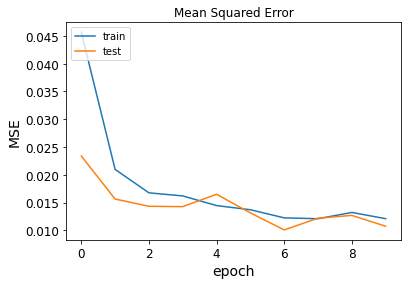

In [ ]:
plot_learning_curves(history)

In [ ]:
X_test[0].shape

(50, 1)

In [ ]:
y_test[0].shape

(10,)

In [ ]:
model.predict(X_test[0])[-1].shape

2/2 [==============================] - 0s 6ms/step


(10,)

2/2 [==============================] - 0s 5ms/step


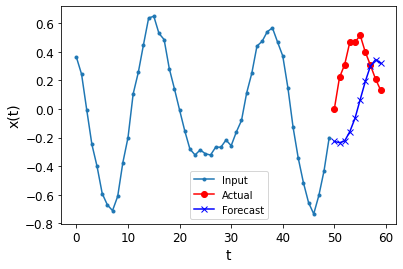

In [ ]:
# a plot of our predictions will give us a better impression
# of how we did
def plot_forecast(model, X_sample, y_sample):

    plt.plot([x for x in range(50)], X_sample, marker=".")
    plt.plot([x for x in range(50,60)], y_sample, color="red", marker="o")
    plt.plot([x for x in range(50,60)], model.predict(X_sample)[-1], color="blue", marker="x")
    plt.xlabel("t")
    plt.ylabel("x(t)")
    plt.legend(["Input", "Actual", "Forecast"])
    plt.show()


sample_id = 0
plot_forecast(model, X_test[sample_id], y_test[sample_id])


2/2 [==============================] - 0s 6ms/step


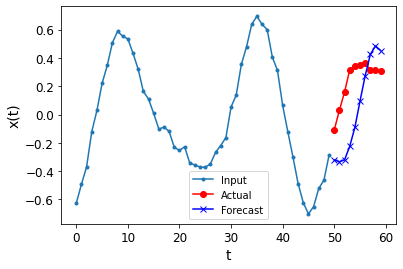

In [ ]:
sample_id = 3
plot_forecast(model, X_test[sample_id], y_test[sample_id])

2/2 [==============================] - 0s 6ms/step


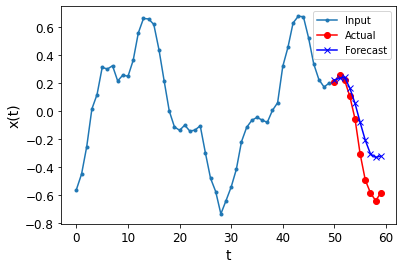

In [ ]:
sample_id = 4
plot_forecast(model, X_test[sample_id], y_test[sample_id])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, None, 20)          440       
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 20)                820       
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
Total params: 1,470
Trainable params: 1,470
Non-trainable params: 0
_________________________________________________________________


# Applying Dropout

- If you build a very deep RNN, it may end up overfitting the training set. 
    - To prevent that, a common technique is to apply dropout
- There are two arguments in Keras RNN layers that you can use 
    - **dropout**: Float between 0 and 1. Fraction of the units to drop for the linear transformation of the inputs.
    - **recurrent_dropout**: Float between 0 and 1. Fraction of the units to drop for the linear transformation of the recurrent state.

In [ ]:
# this is just a 'dummy' dataset, to show you how to apply dropout
# to RNNs
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train / np.float64(255.0)
X_test = X_test / np.float64(255.0)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(
        150, 
        input_shape=(None,28), 
        return_sequences=True , 
        dropout=0.5, 
        recurrent_dropout=0.5
    ),  
    keras.layers.SimpleRNN(15),  
    keras.layers.Dense(10, activation='softmax'),
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=2, validation_data=(X_test, y_test))

11490434/11490434 [==============================] - 0s 0us/step
Epoch 1/2
1875/1875 [==============================] - 66s 35ms/step - loss: 1.7467 - accuracy: 0.3649 - val_loss: 1.2536 - val_accuracy: 0.5577
Epoch 2/2
1875/1875 [==============================] - 64s 34ms/step - loss: 1.3364 - accuracy: 0.5162 - val_loss: 1.1576 - val_accuracy: 0.5789


What about other tricks, like batch normalization? It turns out that BatchNorm cannot be used efficiently with RNNs. Empirical studies have shown that they have next to no effect. A better approach is a technique called Layer Normalization, where instead of normalizing across the batch, you normalize across the feature dimension. There is an example implementation of this on page 513 of the Géron textbook (Hands-On ML, 2nd Ed.). 

# Stock Prediction Example

Let's take what we've learned so far and apply it to a more interesting challenge: predicting stock prices. The main lesson here will be how to prepare your dataset when you are dealing with a single time series. 

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import numpy as np
import pandas as pd

In this case, we'll attempt to predict the stock price of "Altaba", which was an investment company formed from the ashes of Yahoo Inc after Verizon aquired Yahoo's Internet business. An extract of the stock price has been saved out to `aaba.us.txt` and is downloaded below. 

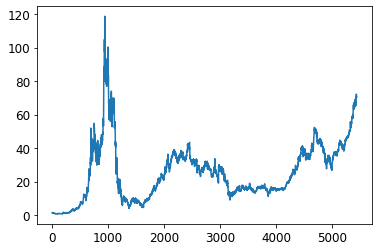

In [ ]:
df_prices = pd.read_csv("https://drive.google.com/uc?id=1X4-nW8phAY6H5FrPhEembOyJ8zmIG1Cz")
df_prices['Close'].plot()

In [ ]:
prices = df_prices['Close'].values

# first let's split the data into a training set we'll learn from, 
# and a validation set we'll try to predict
split_time = 4000
training = prices[:split_time]
holdout = prices[split_time:]

Since we have only one time series, we need to further sub-divide it into slices of smaller 'training' and 'target' data subsets. 




In [ ]:
# we need to create smaller subsets of our 'training' data so that
# our model has multiple samples to train/predict on

# to assist we'll use the helper function below

_a = np.array([1, 2, 3, 4, 5, 6, 7])

def sliding_window(data, window_size):
    # splits our data into windows of the specified size, with stride of 1
    shape = data.shape[:-1] + (data.shape[-1] - window_size + 1, window_size)
    strides = data.strides + (data.strides[-1],)
    return np.lib.stride_tricks.as_strided(data, shape=shape, strides=strides)

sliding_window(_a, window_size=3)

array([[1, 2, 3],
       [2, 3, 4],
       [3, 4, 5],
       [4, 5, 6],
       [5, 6, 7]])

In [ ]:
def windowed_dataset(data, window_size):

  splits = sliding_window(data, window_size)

  # split each window into X_ and y_ components; y_ will be 
  # the final element of the sequence within that window
  X_ = np.array([window[:-1] for window in splits])
  y_ = np.array([window[-1:] for window in splits])

  return X_, y_

X_train, y_train = windowed_dataset(training, window_size=50)
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (3951, 49)
y_train shape: (3951, 1)


In [ ]:
X_valid, y_valid = windowed_dataset(holdout, window_size=50)
print(f"X_valid shape: {X_valid.shape}")
print(f"y_valid shape: {y_valid.shape}")

X_valid shape: (1385, 49)
y_valid shape: (1385, 1)


In [ ]:
# train the model
model = tf.keras.models.Sequential([
    # this first layer merely reshapes our input
    tf.keras.layers.Lambda(
        lambda x: tf.expand_dims(x, axis=-1), 
        input_shape=[None]
    ),
    tf.keras.layers.SimpleRNN(40, activation="tanh"),
    tf.keras.layers.Dense(1),
])

optimizer = tf.keras.optimizers.Adam(lr=1e-2)
model.compile(
    loss=tf.keras.losses.MAE,
    optimizer=optimizer,
    metrics=["mae"]
)
history = model.fit(X_train, y_train, batch_size=128, epochs=50, validation_data=(X_valid, y_valid))

Epoch 1/50
31/31 [==============================] - 3s 90ms/step - loss: 3.8513 - mae: 3.8513 - val_loss: 1.0042 - val_mae: 1.0042
Epoch 2/50
31/31 [==============================] - 1s 39ms/step - loss: 1.0110 - mae: 1.0110 - val_loss: 0.5963 - val_mae: 0.5963
Epoch 3/50
31/31 [==============================] - 1s 34ms/step - loss: 0.8114 - mae: 0.8114 - val_loss: 1.1084 - val_mae: 1.1084
Epoch 4/50
31/31 [==============================] - 1s 33ms/step - loss: 0.7900 - mae: 0.7900 - val_loss: 0.7699 - val_mae: 0.7699
Epoch 5/50
31/31 [==============================] - 1s 35ms/step - loss: 0.7603 - mae: 0.7603 - val_loss: 0.6276 - val_mae: 0.6276
Epoch 6/50
31/31 [==============================] - 1s 35ms/step - loss: 0.7415 - mae: 0.7415 - val_loss: 0.7367 - val_mae: 0.7367
Epoch 7/50
31/31 [==============================] - 1s 35ms/step - loss: 0.6943 - mae: 0.6943 - val_loss: 0.8245 - val_mae: 0.8245
Epoch 8/50
31/31 [==============================] - 1s 34ms/step - loss: 0.6781 - m

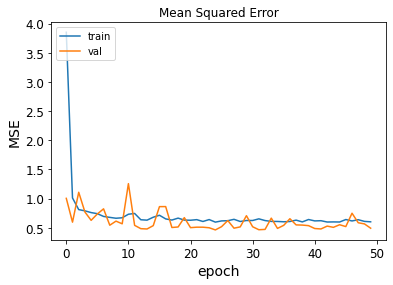

In [ ]:
# let's examine the learning curves
def plot_learning_curves(history):

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Mean Squared Error')
  plt.ylabel('MSE')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

plot_learning_curves(history)

In [ ]:
# let's visualize how good our network is at predicting the _next_ value only;
# we'll repeat this for all datapoints in our holdout set, but we'll always
# feed the RNN the 'ground truth' for the input

def predict_next_step(data, input_sequence_size, num_preds=200):

  ground_truth = np.expand_dims(data, axis=0)

  y_preds = []
  for step in range(num_preds):

    X_in = ground_truth[:, step:step+input_sequence_size]
  
    y_pred_one = model.predict(X_in, verbose=0)
    y_preds.append(y_pred_one)


  return np.concatenate(y_preds).ravel()

preds = predict_next_step(data=holdout, input_sequence_size=49)

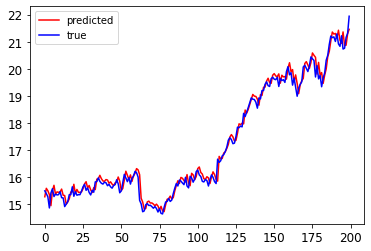

In [ ]:
def plot_performance(preds, true):

  N = len(preds)
  _true = true[:N]

  t = [x for x in range(N)]

  plt.plot(t, preds, color="red")
  plt.plot(t, _true, color="blue")
  plt.legend(["predicted", "true"])
  plt.show()

plot_performance(preds, holdout[49:])

This network seems to do alright at predicting the next value. However, it might simply be guessing a value that is close to the last in the sequence. If we wanted to be able to trust our network to provide us with predictions far into the future, we would be better off attempting to predict the next $N$ timesteps, instead of the next one only. 

We leave this to you as an optional exercise if you'd like to try it. Hint: you'd also have to modify the `windowed_dataset` function to keep the last $N$ elements of each window. You might also want to try a deeper network.  

# Handling Long Sequences

- To train an RNN on long sequences, you will need to run it over many time steps, making the unrolled RNN a very deep network. 
    - Just like any deep neural network it may suffer from the vanishing/exploding gradients problem and take a long time to train.


- Even if you follow all the usual best practices (proper weight initialization, non-saturating activation functions, gradient clipping, faster optimizers, etc), training still tends to take a long time for RNNs. 

- One solution is to unroll the RNN only over a limited number of time steps during training (truncated backpropagation through time). 
    - It can be implemented by truncating the input sequences:
        - Reduce `n_steps` during training. In this case, the model will not be able to learn long-term patterns. 
        - One workaround could be to make sure that these shortened sequences contain both old and recent data, so that the model can learn to use both.
            - what if fine-grained data from last year is actually useful? What if there was a brief but significant event that absolutely must be taken into account, even years later?


- For RNNs, the memory of the first inputs gradually fades away. Some information is lost after each time step. 
- After a while, the RNN’s state contains virtually no trace of the first inputs.
    - For example, say you want to perform sentiment analysis on a long review that starts with the four words “I loved this movie,” but the rest of the review lists the many things that could have made the movie even better. 
    - If the RNN gradually forgets the first four words, it will completely misinterpret the review. 
    - To solve this problem, various types of cells with long-term memory have been introduced. 

# LSTM Cell

- The Long Short-Term Memory (LSTM) cell was proposed in 1973 by Sepp Hochreiter and Jürgen Schmidhuber.

- An LSTM cell will:
    - Converge faster while training
    - Detect long-term dependencies in the data. 
    - In TensorFlow, replace `BasicRNNCell` with `BasicLSTMCell`
        - `lstm_cell = tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)`



- LSTM cells manage two state vectors, and for performance reasons they are kept separate by default. You can change this default behavior by setting `state_is_tuple=False`.


- Architecture:

<center><img src="https://drive.google.com/uc?id=1grOa1piS0PLeZS4Z1ZskQKXzXe8nhjLk" ></center>

- The key idea is that the network can learn what to store in the long-term state, what to throw away, and what to read from it


- The LSTM cell looks exactly like a regular cell, except that its state is split in two vectors: 
    - $h_{(t)}$ the short-term state and 
    - $c_{(t)}$ as the long-term state.


- As the long-term state $c_{(t–1)}$ traverses the network:
    - it first goes through a forget gate, dropping some memories, then 
    - adds some new memories via the addition operation.
    - At each time step, some memories are dropped and some memories are added. 
    
    
- The long-term state is then copied and passed through the `tanh` function, the result is filtered by the output gate. This produces the short-term state $h_{(t)}$. 

- Here is how it works. The current input vector $x_{(t)}$ and the previous short-term state $h_{(t-1)}$ are fed to four different fully connected layers. They all serve a different purpose:
    - The main layer is the one that outputs $g_{(t)}$. It has the usual role of analyzing the current inputs $x_{(t)}$ and the previous $h_{(t-1)}$. 
        - In a basic cell, there is nothing else than this layer
        - In an LSTM cell this layer’s output is partially stored in the long-term state.
    - The three other layers are gate controllers. Their outputs range from 0 to 1. 
        - Their outputs are fed to element-wise multiplication operations, so if they output 0s, they close the gate, and if they output 1s, they open it. Specifically:
            - The forget gate controls which parts of the long-term state should be erased.
            - The input gate controls which parts of $g_{(t)}$ should be added to the long-term state 
            - The output gate controls which parts of the long-term state should be read and output at this time step.



- An LSTM cell can learn to recognize an important input, store it in the long-term state, learn to preserve it for as long as it is needed, and learn to extract it whenever it is needed. 

- They have been amazingly successful at capturing long-term patterns in time series, long texts, audio recordings, and more.


$$
\begin{aligned} \mathbf{i}_{(t)} &=\sigma\left(\mathbf{W}_{x i}^{T} \mathbf{x}_{(t)}+\mathbf{W}_{h i}^{T} \mathbf{h}_{(t-1)}+\mathbf{b}_{i}\right) \\ \mathbf{f}_{(t)} &=\sigma\left(\mathbf{W}_{x f}^{T} \mathbf{x}_{(t)}+\mathbf{W}_{h f}^{T} \mathbf{h}_{(t-1)}+\mathbf{b}_{f}\right) \\ \mathbf{o}_{(t)} &=\sigma\left(\mathbf{W}_{x o}{ }^{T} \mathbf{x}_{(t)}+\mathbf{W}_{h o}{ }^{T} \mathbf{h}_{(t-1)}+\mathbf{b}_{o}\right) \\ \mathbf{g}_{(t)} &=\tanh \left(\mathbf{W}_{x g}{ }^{T} \mathbf{x}_{(t)}+\mathbf{W}_{h g}{ }^{T} \mathbf{h}_{(t-1)}+\mathbf{b}_{g}\right) \\ \mathbf{c}_{(t)} &=\mathbf{f}_{(t)} \otimes \mathbf{c}_{(t-1)}+\mathbf{i}_{(t)} \otimes \mathbf{g}_{(t)} \\ \mathbf{y}_{(t)} &=\mathbf{h}_{(t)}=\mathbf{o}_{(t)} \otimes \tanh \left(\mathbf{c}_{(t)}\right) \end{aligned}
$$

$W_{xi}$, $W_{xf}$, $W_{xo}$, $W_{xg}$ are the weight matrices of each of the four layers for their connection to the input vector $x_{(t)}$.

$W_{hi}$, $W_{hf}$, $W_{ho}$, and $W_{hg}$ are the weight matrices of each of the four layers for their connection to the previous short-term state $h_{(t–1)}$.

$b_i$, $b_f$, $b_o$, and $b_g$ are the bias terms for each of the four layers.

# Peephole Connections

- It may be a good idea to give an RNN a bit more context by letting them peek at the long-term cell state $c_{(t)}$. 
    - An LSTM variant with peephole connections was proposed by Felix Gers and Jürgen Schmidhuber in 2006.
        - The previous long-term state $c_{(t–1)}$ is added as an input to the controllers of the forget gate and the input gate, and the current long-term state $c_{(t)}$ is added as input to the controller of the output gate.

$$
\begin{aligned} f_{t} &=\sigma\left(W_{f} \cdot\left[\boldsymbol{C}_{t-1}, h_{t-1}, x_{t}\right]+b_{f}\right) \\ i_{t} &=\sigma\left(W_{i} \cdot\left[\boldsymbol{C}_{t-1}, h_{t-1}, x_{t}\right]+b_{i}\right) \\ o_{t} &=\sigma\left(W_{o} \cdot\left[\boldsymbol{C}_{t}, h_{t-1}, x_{t}\right]+b_{o}\right) \end{aligned}
$$

In Keras, the LSTM layer is based on the keras.layers.LSTMCell cell, which does not support peepholes. However, the experimental tf.keras.experimental.PeepholeLSTMCell does, so you can create a keras.layers.RNN layer, passing a PeepholeLSTMCell to its constructor.

### Practice with LSTM

Utilizing an LSTM is straightforward. Below we show a minimalistic example. 

In [ ]:
# in this case, we are predicting an output sequence:
# given timesteps 0 through 50, we want our network to
# output timesteps 1 through 51
n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -50:]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -50:]
X_test, y_test = series[9000:, :n_steps], series[9000:, -50:]

In [ ]:
X_train[0].shape, y_train[0].shape

((50, 1), (50, 1))

In [ ]:
# this time we want to return the entire sequence, not just the last value
model = keras.models.Sequential([
    keras.layers.LSTM(
        1, 
        input_shape=[None, 1], 
        activation='tanh', 
        return_sequences= True
    ),
])

optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))

Epoch 1/2
219/219 [==============================] - 7s 8ms/step - loss: 0.1546 - val_loss: 0.1114
Epoch 2/2
219/219 [==============================] - 1s 6ms/step - loss: 0.1011 - val_loss: 0.0939


In [ ]:
# suppose we want to add a dense layer to the output, which should be applied to
# the output of every timestep
model = keras.models.Sequential([
    keras.layers.LSTM(
        10, 
        input_shape=[None, 1], 
        activation='tanh', 
        return_sequences=True, 
        use_bias=True
    ),
    keras.layers.TimeDistributed(
        keras.layers.Dense(1, activation='sigmoid',use_bias=True))
])

optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))

Epoch 1/2
219/219 [==============================] - 4s 11ms/step - loss: 0.1580 - val_loss: 0.1121
Epoch 2/2
219/219 [==============================] - 2s 10ms/step - loss: 0.0904 - val_loss: 0.0805


# GRU Cell


- The Gated Recurrent Unit (GRU) cell was proposed by Kyunghyun Cho et al. in a 2014

<center><img src="https://drive.google.com/uc?id=1CDtY4r0HKSOTzAsqeNlXbNqOsGetOtqW" ></center>


- The GRU cell is a simplified version of the LSTM cell, and it seems to perform just as well:
    - Both state vectors are merged into a single vector $h_{(t)}$.
    - A single gate controller controls both the forget gate and the input gate:
        - If the gate controller outputs a 1, the forget gate is open and the input gate is closed. 
        - If it outputs a 0, the opposite happens. 
        - Whenever a memory must be stored, the location is erased first. 
        
    - There is no output gate; 
    - The full state vector is output at every time step. 
    - There is a new gate controller that controls which part of the previous state will be shown to the main layer.

### Equations

$$
\begin{aligned} \mathbf{z}_{(t)} &=\sigma\left(\mathbf{W}_{x z} \mathbf{x}_{(t)}+\mathbf{W}_{h z}^{T} \mathbf{h}_{(t-1)}+\mathbf{b}_{z}\right) \\ \mathbf{r}_{(t)} &=\sigma\left(\mathbf{W}_{x r}{ }^{T} \mathbf{x}_{(t)}+\mathbf{W}_{h r}{ }^{T} \mathbf{h}_{(t-1)}+\mathbf{b}_{r}\right) \\ \mathbf{g}_{(t)} &=\tanh \left(\mathbf{W}_{x g}{\mathbf{x}} \mathbf{x}_{(t)}+\mathbf{W}_{h g}{ }^{T}\left(\mathbf{r}_{(t)} \otimes \mathbf{h}_{(t-1)}\right)+\mathbf{b}_{g}\right) \\ \mathbf{h}_{(t)} &=\mathbf{z}_{(t)} \otimes \mathbf{h}_{(t-1)}+\left(1-\mathbf{z}_{(t)}\right) \otimes \mathbf{g}_{(t)} \end{aligned}
$$

- In Tensorflow:
    `gru_cell = tf.contrib.rnn.GRUCell(num_units=n_neurons)`
- LSTM or GRU cells are one of the main reasons behind the success of RNNs in recent years, in particular for applications in natural language processing (NLP).

### Exercise 1

Practice building a deep RNN to predict the next value in the dataset found in `aard.us.txt`

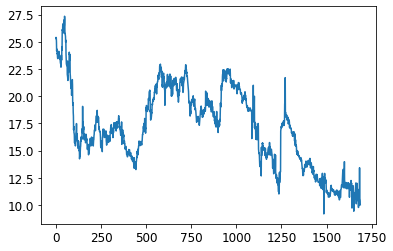

In [ ]:
pdf_aard = pd.read_csv("https://drive.google.com/uc?id=1hTc4qW8aCTCNY35ksGbXTdSMe7djB2FD")
pdf_aard['Close'].plot()


In [ ]:
### Your Response here 

In [ ]:
### Your Response here 

In [ ]:
### Your Response here 

In [ ]:
### Your Response here 

In [ ]:
### Your Response here 

In [ ]:
### Your Response here 

In [ ]:
### Your Response here 

In [ ]:
### Your Response here 

In [ ]:
### Your Response here 

### Exercise 2

Try Deeper RNN network and check the training loss and plot predictions versus actual  


In [ ]:
### Your Response here 

In [ ]:
### Your Response here 

In [ ]:
### Your Response here 

### Exercise 3

Try LSTM and GRU network and check the training loss and plot predictions versus actual  


In [ ]:
### Your Response here 

In [ ]:
### Your Response here 

In [ ]:
### Your Response here 

In [ ]:
### Your Response here 

# References 

- [Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition (Chapter 15)](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/)

- [Deep Learning book (Chapter 10)](http://www.deeplearningbook.org/contents/rnn.html#pf7)

# Additional Resources

- Understanding LSTMs
    - https://colah.github.io/posts/2015-08-Understanding-LSTMs/
- Recurrent Neural Networks w/ TF:
    - https://www.tensorflow.org/tutorials/sequences/recurrent
    
- Keras conv networks:
    - https://keras.io/layers/recurrent/
    - https://keras.io/applications/
    
- Deep Learning book
    - Ian Goodfellow and Yoshua Bengio and Aaron Courville
    - https://www.deeplearningbook.org/contents/rnn.html
    
- Deep Learning with Python 
    - [Understanding Recurrent Neural Networks](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/6.2-understanding-recurrent-neural-networks.ipynb)

- [Understanding LSTM](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)

- [Stock Prediction Example](https://github.com/DarkKnight1991/Stock-Price-Prediction)
- [Classical Piano Example](https://github.com/Skuldur/Classical-Piano-Composer)
